In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

In [1]:
import os 
print os.getenv("HOME")
wd = os.path.join( os.getenv("HOME"),"mpi_tmpdir")
if not os.path.isdir(wd):
    os.mkdir(wd)
os.chdir(wd)
print "WD is now:",os.getcwd()

/home/users/marcin.kostur
WD is now: /home/users/marcin.kostur/mpi_tmpdir


In [3]:
%%writefile mpi002.py

from mpi4py import MPI 
import numpy as np

#number of procesess:

comm = MPI.COMM_WORLD
No_processes = comm.Get_size()
process_rank=comm.Get_rank()

#constants

N=100
dt=0.00001
Niter=1110
D=1
h=1./(N-1)
C=D*dt/h**2
a=0
b=0

x = np.linspace(0,1.,N)
#area:

if process_rank==0:    

    U=np.zeros(N)
    U[N//2]=1./h

else: U=np.empty(N)

#subareas:
    
U_local=np.empty((N/No_processes)+2)
comm.Scatter(U, U_local[1:-1])


#computation

if process_rank==0:

    U_local[0]=a

elif process_rank==1:

    U_local[-1]=b    


for i in xrange(Niter):

    if process_rank==0:
        data0=U_local[-2]
        comm.send(data0, dest=1)
        U_local[-1]=comm.recv(source=1)
        
    elif process_rank==1:
        U_local[0]=comm.recv(source=0)
        data1=U_local[1]
        comm.send(data1, dest=0)
        
        
    U_local[1:-1]=U_local[1:-1]+C*(U_local[2:]+U_local[:-2]-2*U_local[1:-1])

if process_rank==0:
    U_local=U_local[1:-1]

elif process_rank==1:
    U_local=U_local[1:-1]

comm.Gather(U_local, U)

if process_rank==0:
    np.savez("Uout",U=U,x=x)



Writing mpi002.py


In [4]:
!mpirun -n 2 python mpi002.py

In [5]:
data = np.load('Uout.npz')

NameError: name 'np' is not defined

In [6]:
data.files

NameError: name 'data' is not defined

In [10]:
U = data['U']
x = data['x']

In [11]:
U.shape

(100,)

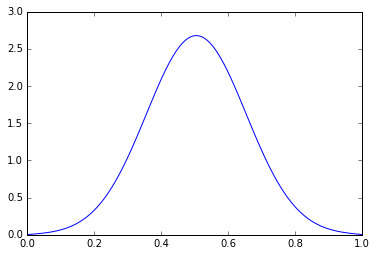

In [12]:
plt.plot(x,U)